# 1. Install PIP's

In [106]:
# geo files for Brazil
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


# 2. Import Packages

In [107]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

# 3. Load Data

In [108]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [109]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [110]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [111]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Remove Space Blank Excessive and Remove Broke Line

In [112]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.replace('\n', ' ')
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
full_df = full_df[full_df['review_comment_message'].str.strip() != '']

### 4.5. Drop Duplicates and NA

In [113]:
full_df = full_df.drop_duplicates(subset=['review_id'])
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()
full_df = full_df[~full_df['review_comment_message'].str.contains('nan')]
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

### 4.6. Conversion Column Message in Lower Case

In [114]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.lower()

### 4.7. Removing Punctuation, Exemple (".", "!")

In [115]:
punct = string.punctuation
punct = punct.replace("'","")
full_df['review_comment_message'] = full_df['review_comment_message'].str.translate(str.maketrans("","",punct))

### 4.8. Space removed at the beginning and end of the message

In [116]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()

### 4.9. Removing Emoji

In [117]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte e símbolos de mapa
                           u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: emoji_pattern.sub(r'', x))

### 4.10. Removing Sites and Blogs

In [118]:
http = r"http\S+|www\.\S+"
pattern = re.compile(r"({})".format(http))
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: pattern.sub(r'', x))

### 4.11. Removing Accentuation

In [119]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: unidecode(x))

### 4.12. Lematization

In [120]:
nlp = spacy.load('pt_core_news_sm')
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

### 4.13. Remove Numbers

In [121]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\d+', '', x))

### 4.14. Join Word "Nao" with Next Word

In [122]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'nao\s+(\w+)', r'nao\1', x))

In [123]:
full_df.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng
0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,naotestar o produto ainda mas ele vir correto e em bom condicoe apenas o caixa que vir bem amassar e danificar o que ficarar chato pois se tratar de um presente,2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,muito bom o produto,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727
448,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,o produto ser exatamente o que eu esperar e estar descrito em o site e chegar bem antes de o data prever,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299
620,e07549ef5311abcc92ba1784b093fb56,2,NaN,fiquei tristir por n ter eu atendir,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111
1468,15898b543726a832d4137fbef5d1d00e,1,NaN,aguardar retorno de o loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869


# 5. Previus Analyze

In [124]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,39901,a54f0611adc9ed256b57ede6b6eb5114,15.28
1,review_score,int64,0,5,4,1.90
2,review_comment_title,object,30243,4064,NaN,10.00
3,review_comment_message,object,0,32610,naotestar o produto ainda mas ele vir correto e em bom condicoe apenas o caixa que vir bem amassar e danificar o que ficarar chato pois se tratar de um presente,14.23
4,review_creation_date,datetime64[ns],0,618,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,datetime64[ns],0,39875,2017-10-12 03:43:48,15.28
6,product_id,object,0,17919,87285b34884572647811a353c7ac498a,13.17
7,geolocation_lat,float64,0,1891,-23.680114,8.82
8,geolocation_lng,float64,0,1891,-46.452454,8.82


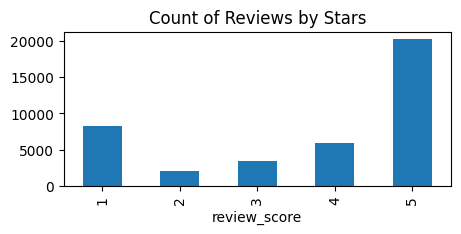

In [125]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [126]:
example = full_df['review_comment_message'].iloc[4]
print(example)

aguardar retorno de o loja


# 6. Training Model

### 6.1. Separeting Dataframe Training and Dataframe Test After Training

In [164]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.95, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

In [166]:
df_positive = df_train[df_train['review_score'] >= 3]  # considerando 3, 4 e 5 como positivos
df_negative = df_train[df_train['review_score'] < 3]  # considerando 1 e 2 como negativos

# Igualar o número de amostras positivas e negativas
df_positive_equal = df_positive.sample(n=len(df_negative), random_state=42)

# Verificar o número de amostras após o balanceamento
print("Número de amostras positivas (após balanceamento):", len(df_positive_equal))

# Concatenar os DataFrames positivo e negativo igualizados
df_balanced = pd.concat([df_positive_equal, df_negative], ignore_index=True)

# Verificar novamente o número de amostras positivas e negativas no DataFrame balanceado
print("Número de amostras positivas no DataFrame balanceado:", len(df_balanced[df_balanced['review_score'] >= 3]))
print("Número de amostras negativas no DataFrame balanceado:", len(df_balanced[df_balanced['review_score'] < 3]))

Número de amostras positivas (após balanceamento): 9752
Número de amostras positivas no DataFrame balanceado: 9752
Número de amostras negativas no DataFrame balanceado: 9752


### 6.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [167]:
df_balanced['sentiment'] = df_balanced['review_score'].apply(lambda x: 0 if x in [1,2] else 1)

In [168]:
df_balanced.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,sentiment
0,234c62f4176082cdf11f9c8b806be428,5,Bom produto,grande e confortavel,2018-08-15,2018-08-19 12:27:49,bbc3a3f2596e849548463e3a46d833f0,-22.541720,-47.427681,1
1,e98d6e4946f31d8e1398284b30e2bb9a,5,NaN,o produto chegar com agilidade,2017-08-22,2017-08-23 00:38:33,51b10a13b460cebc64e1325e7f228ae8,-22.382941,-46.946641,1
2,25ef44d9d1ebcc4828775fe824217661,4,NaN,otimo,2017-08-23,2017-08-23 23:33:36,be62243c73473ddb40dca0d1cf38bc87,-23.540828,-46.512303,1
3,39f79f67e5dd20b5ea25613e5f501ed8,5,NaN,muito bom obrigar,2017-08-25,2017-08-25 22:06:56,154e7e31ebfa092203795c972e5804a6,-23.665703,-46.518082,1
4,4e8c86732da5e01d040d145bc894e7c8,4,NaN,o entrega ser fazer em o prazo,2018-01-11,2018-01-12 03:53:12,4308439e0d80d5fe03f17ba83b57c493,-23.523996,-46.512943,1


### 6.3. Selecting Columns Necessary for Training

In [169]:
selected_columns = ['review_comment_message', 'sentiment']
df_classification = df_balanced.loc[:, selected_columns]

In [170]:
df_classification.head(5)

,review_comment_message,sentiment
0,grande e confortavel,1
1,o produto chegar com agilidade,1
2,otimo,1
3,muito bom obrigar,1
4,o entrega ser fazer em o prazo,1


### 6.4. Divising Dataframe Between Train and Test

In [171]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['review_comment_message'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 6.5. Inicializing Training IA

In [172]:
cv = CountVectorizer()

In [173]:
ctmTr = cv.fit_transform(comment_train)
comment_test_dtm = cv.transform(comment_test)

In [174]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [175]:
normalization.fit(ctmTr)
X = normalization.transform(ctmTr)

In [176]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(50,25,25),
                                   activation='relu',
                                   solver='sgd',
                                   max_iter=50,
                                   early_stopping=True,
                                   n_iter_no_change=10,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train)

Iteration 1, loss = 0.69820244
Validation score: 0.651505
Iteration 2, loss = 0.63703719
Validation score: 0.711083
Iteration 3, loss = 0.58466133
Validation score: 0.737988
Iteration 4, loss = 0.52407838
Validation score: 0.759129
Iteration 5, loss = 0.45279235
Validation score: 0.777707
Iteration 6, loss = 0.37782636
Validation score: 0.792441
Iteration 7, loss = 0.30957923
Validation score: 0.801409
Iteration 8, loss = 0.25451697
Validation score: 0.809097
Iteration 9, loss = 0.21312440
Validation score: 0.812300
Iteration 10, loss = 0.18326489
Validation score: 0.817425
Iteration 11, loss = 0.16188961
Validation score: 0.816784
Iteration 12, loss = 0.14614162
Validation score: 0.819347
Iteration 13, loss = 0.13441178
Validation score: 0.820628
Iteration 14, loss = 0.12519239
Validation score: 0.823190
Iteration 15, loss = 0.11782118
Validation score: 0.827034
Iteration 16, loss = 0.11186228
Validation score: 0.823831
Iteration 17, loss = 0.10669692
Validation score: 0.825112
Iterat

# 7. Analyze Performance IA

### 7.1. Score

In [177]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8641374006664958

### 7.2. Graph Loss During Training

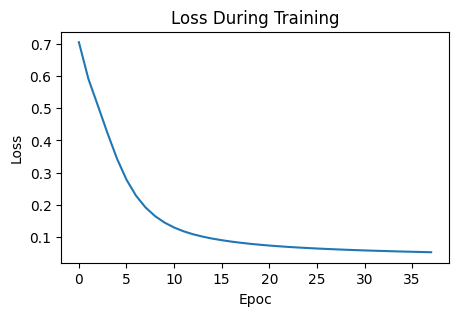

In [157]:
plt.figure(figsize=(5, 3))
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoc')
plt.ylabel('Loss')
plt.show()

### 7.3. Confusion Matrix

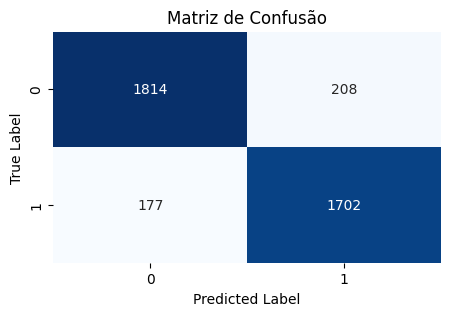

In [158]:
# Fazer previsões no conjunto de teste
predictions = analyze_sentiment.predict(X_test)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(sentiment_test, predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 7.4. Curve ROC

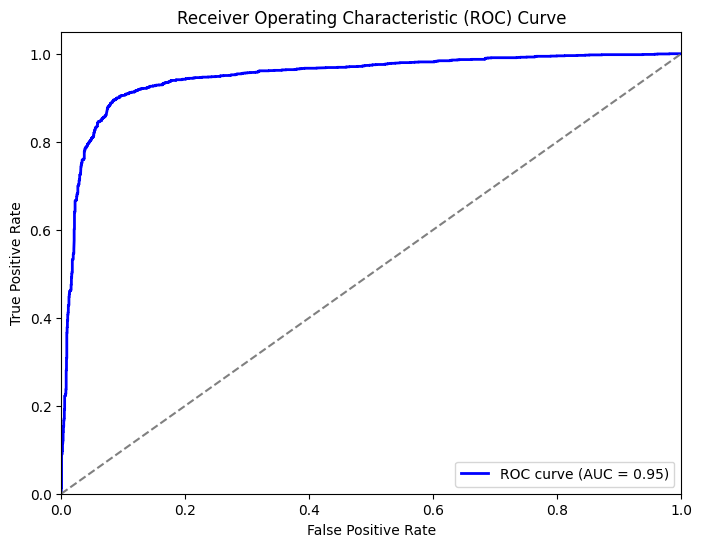

In [159]:
# Calcular as probabilidades previstas para a classe positiva
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

# Calcular a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 8. Test and Deploy IA

In [178]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = cv.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

print(df_remaining[['review_comment_message', 'review_score', 'sentimento_predito']])

df_remaining[['review_id','review_comment_message', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


                                                                                    review_comment_message  \
0                                                                                entregar antes de o prazo   
1      satisfeito  recebir bem antes de o prazo estimar so falta testalo naoacompanhar o cartucho de tinta   
2                                                      gostar de o que compr e ficar muito legal em o moto   
3                                                                                          bom atendimento   
4                                       indico produto de alto qualidade recebir antes de o prazo combinar   
...                                                                                                    ...   
39802                          otimo comprar por este site o mercadoria chegar antes de o prazo determinar   
39803                     ele naoe um mini cajon e um shaker ou ser um chocalho que imitar o cajon pessimo   
39804     

## division

In [ ]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Criar o modelo MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo usando a pesquisa em grade
grid_search.fit(X, sentiment_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo
print("Acurácia da melhor configuração no conjunto de validação:")
print(grid_search.best_score_)